# This notebook will explore gene variability in stages and clusters

## Imports

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import scvelo as scv
from scipy import stats
import os
import matplotlib
import pickle
%matplotlib inline
import palantir
import harmony
import random
np.random.seed(0)
random.seed(0)

## Settings

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
sc.settings.verbosity = 0  

## Loading individual datasets

In [5]:
def save_intermediate_files(datasets, temp_dir, file_name_template, identifier):
    for d in datasets:
        file = os.path.join('.', temp_dir, file_name_template + '_' + d.obs[identifier][0] + '.h5ad')
        d.write(file, compression='gzip')
        
identifiers = ['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27']
      
def load_intermediate_files(temp_dir, file_name_template, identifiers):
    ob_list = []
    for i in identifiers:
        file = os.path.join('.', temp_dir, file_name_template + '_' + i+ '.h5ad')
        ob_list.append(sc.read_h5ad(file))
    return ob_list

In [6]:
import sys
sys.path.append('../Integrated_analysis/')
from Integrate import concat_for_harmony, adata_to_df

In [8]:
#loading and concatenating files
stages = ['st08', 'st10.5', 'st12', 'st13', 'st16', 'st18', 'st20', 'st22', 'st24', 'st27']
adatas = load_intermediate_files( '../intermediate_files', 'zUMI_raw_singlets' , stages)



In [9]:
counts = concat_for_harmony(adatas, stages)
norm_df = harmony.utils.normalize_counts(counts)
hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=2000)
data_df = harmony.utils.log_transform(norm_df.loc[:,hvg_genes])


st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27
Concatenating data..


In [10]:
def adata_hvg(adata, N_genes = 1000):
    print(adata.obs.stage[0])
    counts = pd.DataFrame(data = adata.X.todense(), 
                          index = adata.obs_names,
                          columns = adata.var_names)
    norm_df = harmony.utils.normalize_counts(counts)
    hvg_genes = harmony.utils.hvg_genes(norm_df, no_genes=N_genes)
    return hvg_genes.tolist()

In [11]:
def flatten(ls):
    return [x for y in ls for x in y]
hvg_genes_per_data = list(set(flatten([adata_hvg(x, N_genes = 500) for x in adatas])))

st08
st10.5
st12
st13
st16
st18
st20
st22
st24
st27


In [12]:
len(hvg_genes_per_data)

3906

In [13]:
#Cell type colors from integrated annotation
colors = [
[(0.3388235294117647, 0.7117262591311034, 0.40584390618992694),0, 2],
[(0.7371472510572856, 0.895517108804306, 0.7108342945021145),1, 4],
[(0.5573241061130334, 0.8164244521337947, 0.546958861976163),2, 3],
[(0.7364705882352941, 0.08, 0.10117647058823528),3, 9],
[(0.7777777777777778, 0.7777777777777778, 0.7777777777777778),4, 1],
[(0.8828143021914648, 0.9546943483275664, 0.8621914648212226),5, 5],
[(0.9466666666666667, 0.26823529411764707, 0.19607843137254902),6, 8],
[(0.586082276047674, 0.586082276047674, 0.586082276047674),7, 0],
[(0.996078431372549, 0.8091503267973856, 0.39607843137254906),8, 14],
[(0.7752402921953095, 0.8583006535947711, 0.9368242983467897),9, 10],
[(0.41708573625528644, 0.6806305267204922, 0.8382314494425221),10, 11],
[(0.5513264129181085, 0.537916186082276, 0.7524490580545944),11, 13],
[(0.9874509803921568, 0.5411764705882353, 0.41568627450980394),12, 7],
[(0.1271049596309112, 0.4401845444059977, 0.7074971164936563),13, 12],
[(0.9913725490196079, 0.7913725490196079, 0.7082352941176471),14, 6]]
colors = pd.DataFrame(colors, columns = ['color', 'org_clust', 'clust_order'])

In [15]:
#Setting up stage and cluster annotation

In [16]:
tp = pd.Series(index=data_df.index)
for t in stages:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t

In [17]:
import pickle
with open('../intermediate_files/clusters', "rb") as f:
    clusters = pickle.load( f)

In [32]:
#Remove non-informative gene names
#data = data_df.copy()
# for all genes


data = norm_df.loc[:,hvg_genes_per_data]
genes_sub = [x for x in data.columns if 'LOC' not in x]
genes_sub = [x for x in genes_sub if 'Xetrov' not in x]
genes_sub = [x for x in genes_sub if 'Xelaev' not in x]
genes_sub = [x for x in genes_sub if 'MGC' not in x]
genes_sub = [x for x in genes_sub if '|loc' not in x]
print('Subsetting to {} genes'.format(len(genes_sub)))
data = data.loc[:,genes_sub]

Subsetting to 2979 genes


In [33]:
#data.to_csv('Sup_tables/hvgs.tsv', sep = '\t')

In [34]:
#Load affinity matrix
with open('../intermediate_files/aug_aff', "rb") as f:
    aug_aff = pickle.load( f)

In [35]:
#Diffusion maps for palantir
dm_res = palantir.utils.run_diffusion_maps(aug_aff,n_components=20,
    knn=20)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = data_df.index

In [36]:
#Magic imputation
imp_df = palantir.utils.run_magic_imputation(norm_df, dm_res)

In [37]:
#Search by gene id
def find(gene):
    return list(imp_df.columns[imp_df.columns.str.match(r'^(gene[0-9]+\|){}'.format(gene))])

# Variability of gene expression 

In [16]:
sns.set_style("ticks", {'font.sans-serif': 'Arial'})

In [17]:
sns.reset_orig()
sns.reset_defaults()

In [17]:
data = norm_df

In [18]:
from scipy.stats import variation 



var_hvg = variation(data.loc[:,hvg_genes_per_data].T.replace(0, np.NaN), axis=0, nan_policy = 'omit')
var = variation(norm_df.T.replace(0, np.NaN), axis=0, nan_policy = 'omit')

mean_hvg = data.loc[:,hvg_genes_per_data].T.replace(0, np.NaN).mean()
mean = norm_df.T.replace(0, np.NaN).mean()


In [19]:
df = pd.concat([tp, 
                clusters, 
                pd.Series(var, index = clusters.index), 
                pd.Series(var_hvg, index = clusters.index),
                pd.Series(mean, index = clusters.index), 
                pd.Series(mean_hvg, index = clusters.index)
               ], axis = 1)
df.columns = ['stage', 'clusters', 'CV', 'CV (HVG)', 'mean', 'mean (HVG)']

In [23]:
df.CV.to_csv('CV.tsv', sep = '\t')

In [116]:
df['stage_continuous'] = df.stage.str.split('st').apply(lambda x: float(x[1]))

In [117]:
N_cells = tp.value_counts()

In [118]:
genes = pd.concat([(data > 0).sum(axis = 1), tp], axis = 1)
genes.columns = ['Genes', 'stage']
genes = genes.groupby('stage').mean()

In [119]:
anno = pd.concat([N_cells, genes], axis = 1)
anno.columns = ['N_cells', 'Genes']

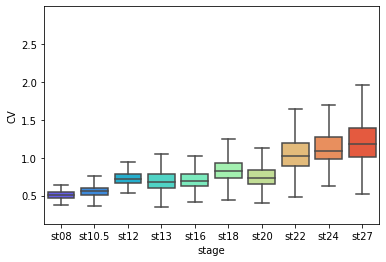

In [121]:

cluster_colors = pd.Series(sns.color_palette(
            'rainbow', 10), index=['st08','st10.5','st12','st13','st16','st18','st20','st22','st24','st27'])
fig, ax = plt.subplots()
sns.boxplot(data = df, x = 'stage', y = 'CV', palette=cluster_colors,
            fliersize = 0, ax = ax)


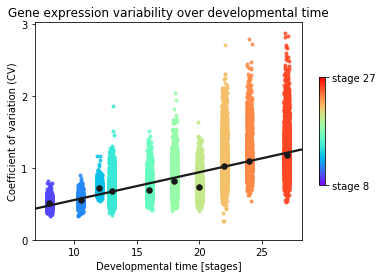

In [122]:
def get_st_from_float(fl):
    try:
        if fl == 8.:
            st = ''.join(['st', '08'])
        elif fl == 10.5:
            st = ''.join(['st', '10.5'])
        else:
            st = ''.join(['st', str(int(fl))])
    except:
        st = ''.join(['st', str(float(fl))]) 
    return st

import matplotlib.colors as mcolors
import matplotlib.cm as cm

normalize = mcolors.Normalize(vmin=8, vmax=27)
colormap = cm.rainbow

#nValues = [8, 27]
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
#scalarmappaple.set_array(nValues)


fig, ax = plt.subplots()
for st in df.stage_continuous.unique():
    da = df[df.stage_continuous == st]
    sns.regplot(x="stage_continuous", y="CV", data=da, 
                scatter=True,
                fit_reg = False, 
                color =cluster_colors[get_st_from_float(st)], 
               x_jitter = 0.2, marker = '.')
    
sns.regplot(x="stage_continuous", y="CV", data=df, 
            scatter=True, 
            x_bins=df.stage_continuous.unique(),
            ax = ax , scatter_kws = {'s' : 30},
            color = 'k', 
            x_estimator = np.median)
ax.set_xlabel('Developmental time [stages]')
ax.set_yticks([0, 1,2,3])
ax.set_ylabel('Coefficient of variation (CV)')
ax.set_title('Gene expression variability over developmental time')

plt.colorbar(scalarmappaple, ticks = [8, 27], shrink = 0.5, orientation = 'vertical', format='stage %s')
plt.show()




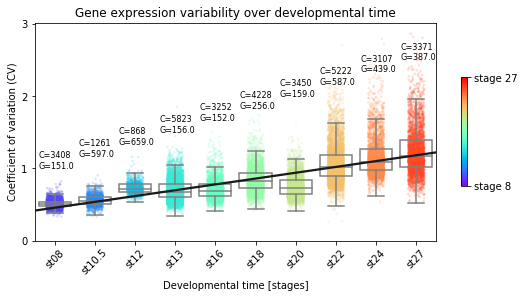

In [123]:
from matplotlib.collections import PathCollection

mapper = {x:y for x,y in zip(df.stage.unique(), range(len(df.stage.unique())))}
df['stage_numeric'] = df.stage.map(mapper)

fig, ax = plt.subplots(figsize = (9,4))



sns.stripplot(data = df, x = 'stage_numeric', y = 'CV',  palette=cluster_colors,
              ax = ax, jitter = 0.2, 
              zorder=1, marker = '.',
              alpha = 0.2)

sns.boxplot(data = df, x = 'stage_numeric', y = 'CV',  
            color = 'w', #palette=cluster_colors,
            fliersize = 0, linewidth = 1.5, saturation=0,
            ax = ax, zorder = 3)
plt.setp(ax.lines, color='grey', zorder = 3)
plt.setp(ax.artists, edgecolor = 'grey', facecolor='w', zorder = 3)


for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .0))

for idx, i in enumerate(tp.unique()):
    ax.text(idx-0.4, 1 +idx / 6, 
            "C={}\nG={}".format(anno.loc[i, 'N_cells'], round(anno.loc[i, 'Genes'])), 
            transform=ax.transData, fontsize=8)

sns.regplot(x="stage_numeric", y="CV", 
            data=df, 
            scatter=False, 
            x_bins=df.stage_numeric.unique(),
            ax = ax , 
            color = 'k', 
            x_estimator = np.median, line_kws={"zorder":5})


ax.set_xlabel('Developmental time [stages]')
ax.set_yticks([0, 1,2,3])
ax.set_xticklabels(df.stage.unique(), rotation = 45)
ax.set_ylabel('Coefficient of variation (CV)')
ax.set_title('Gene expression variability over developmental time')

plt.colorbar(scalarmappaple, ticks = [8, 27], shrink = 0.5, orientation = 'vertical', format='stage %s')
plt.savefig('figures/CV_vs_stages.pdf')


In [77]:
N_cells = clusters.value_counts()

In [78]:
genes = pd.concat([(data > 0).sum(axis = 1), clusters], axis = 1)
genes.columns = ['Genes', 'clusters']
genes = genes.groupby('clusters').mean()

In [79]:
anno = pd.concat([N_cells, genes], axis = 1)
anno.columns = ['N_cells', 'Genes']

In [73]:
order = colors.sort_values('clust_order').org_clust

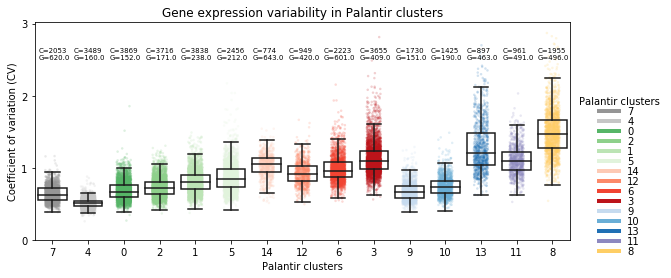

In [83]:
fig, ax = plt.subplots(figsize = (12,4))


sns.stripplot(data = df, x = 'clusters', y = 'CV',  palette=colors.sort_values('clust_order').color,
              ax = ax, jitter = 0.2, order = order, 
              zorder=1, marker = '.',
              alpha = 0.2)


sns.boxplot(data = df, 
            x = 'clusters',
            y = 'CV', 
            order = order,
            color = 'w', 
            fliersize = 0, ax = ax, zorder = 3, linewidth = 1.5
           )

for idx, i in enumerate(order):
    ax.text(idx-0.4, 2.5, 
            "C={}\nG={}".format(anno.loc[i, 'N_cells'], round(anno.loc[i, 'Genes'])), 
            transform=ax.transData, fontsize=7)

plt.setp(ax.lines, color='k', zorder = 3)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w', zorder = 3)

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .0))
    
from matplotlib.lines import Line2D    
custom_lines = [Line2D([0], [0], color=colors.color[i], lw=4) for i in colors.sort_values('clust_order').org_clust]

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


ax.legend(custom_lines, colors.sort_values('clust_order').org_clust,bbox_to_anchor=(1, 0.7), frameon=False, title = 'Palantir clusters', labelspacing = 0)
ax.set_xlabel('Palantir clusters')
ax.set_yticks([0, 1,2,3])
ax.set_ylabel('Coefficient of variation (CV)')
ax.set_title('Gene expression variability in Palantir clusters')
plt.savefig('figures/CV_vs_clusters2.pdf')

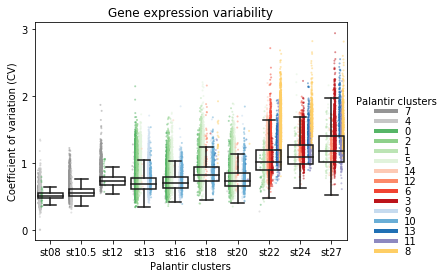

In [97]:
fig, ax = plt.subplots(figsize = (7,4))

sns.stripplot(data = df, 
              x = 'stage', 
              y = 'CV (HVG)',  
              hue = 'clusters', 
              palette=colors.sort_values('clust_order').color,
              hue_order = colors.sort_values('clust_order').org_clust,
              size = 2, jitter = 0.3, alpha = 0.5, ax = ax, dodge = True)
sns.boxplot(data = df, 
            x = 'stage',
            y = 'CV', 
            color = 'w',
            fliersize = 0,
           ax = ax)

plt.setp(ax.lines, color='k', zorder = 3)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w', zorder = 3)

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .0))
    
    
    
from matplotlib.lines import Line2D    
custom_lines = [Line2D([0], [0], color=colors.color[i], lw=4) for i in colors.sort_values('clust_order').org_clust]

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])


ax.legend(custom_lines, colors.sort_values('clust_order').org_clust,bbox_to_anchor=(1, 0.7), frameon=False, title = 'Palantir clusters', labelspacing = 0)
ax.set_xlabel('Palantir clusters')
ax.set_yticks([0, 1,2,3])
ax.set_ylabel('Coefficient of variation (CV)')
ax.set_title('Gene expression variability')
plt.savefig('figures/CV_vs_st_cl_low_a.pdf')

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## Gene dynamics

In [25]:
def find(gene):
    return list(imp_df.columns[imp_df.columns.str.match(r'^(gene[0-9]+\|){}'.format(gene))])

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


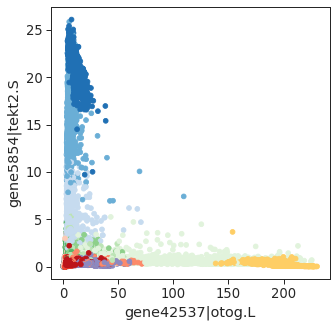

In [23]:

def plot_comb_scatter(gene_x, gene_y, groupby):
    fig, ax = plt.subplots(figsize = (5,5 ))
    ax.scatter(x = imp_df.loc[:, gene_x], y = imp_df.loc[:, gene_y], color = groupby.map(colors.color))
    ax.set_xlabel(gene_x)
    ax.set_ylabel(gene_y)
    
plot_comb_scatter(gene_x = 'gene42537|otog.L', gene_y = 'gene5854|tekt2.S', groupby = clusters)

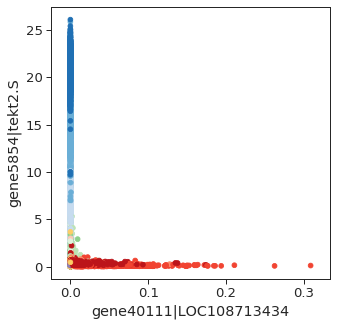

In [39]:
plot_comb_scatter(gene_x = 'gene40111|LOC108713434', gene_y = 'gene5854|tekt2.S', groupby = clusters)

In [25]:
otog = ['gene42537|otog.L', 'gene40111|LOC108713434']
other = ['gene9638|spdef.S','gene7275|tekt2.L', 'gene5854|tekt2.S']

In [33]:
otog = ['gene94|pou5f3.2.L', 'gene5617|tubb4b.L','gene15250|eef1a1o.L', 'gene42537|otog.L', 'gene13635|atp6v1g3.S', 'gene13442|pfn1.L']

other = ['gene94|pou5f3.2.L', 'gene5617|tubb4b.L','gene15250|eef1a1o.L', 'gene42537|otog.L', 'gene13635|atp6v1g3.S', 'gene13442|pfn1.L']


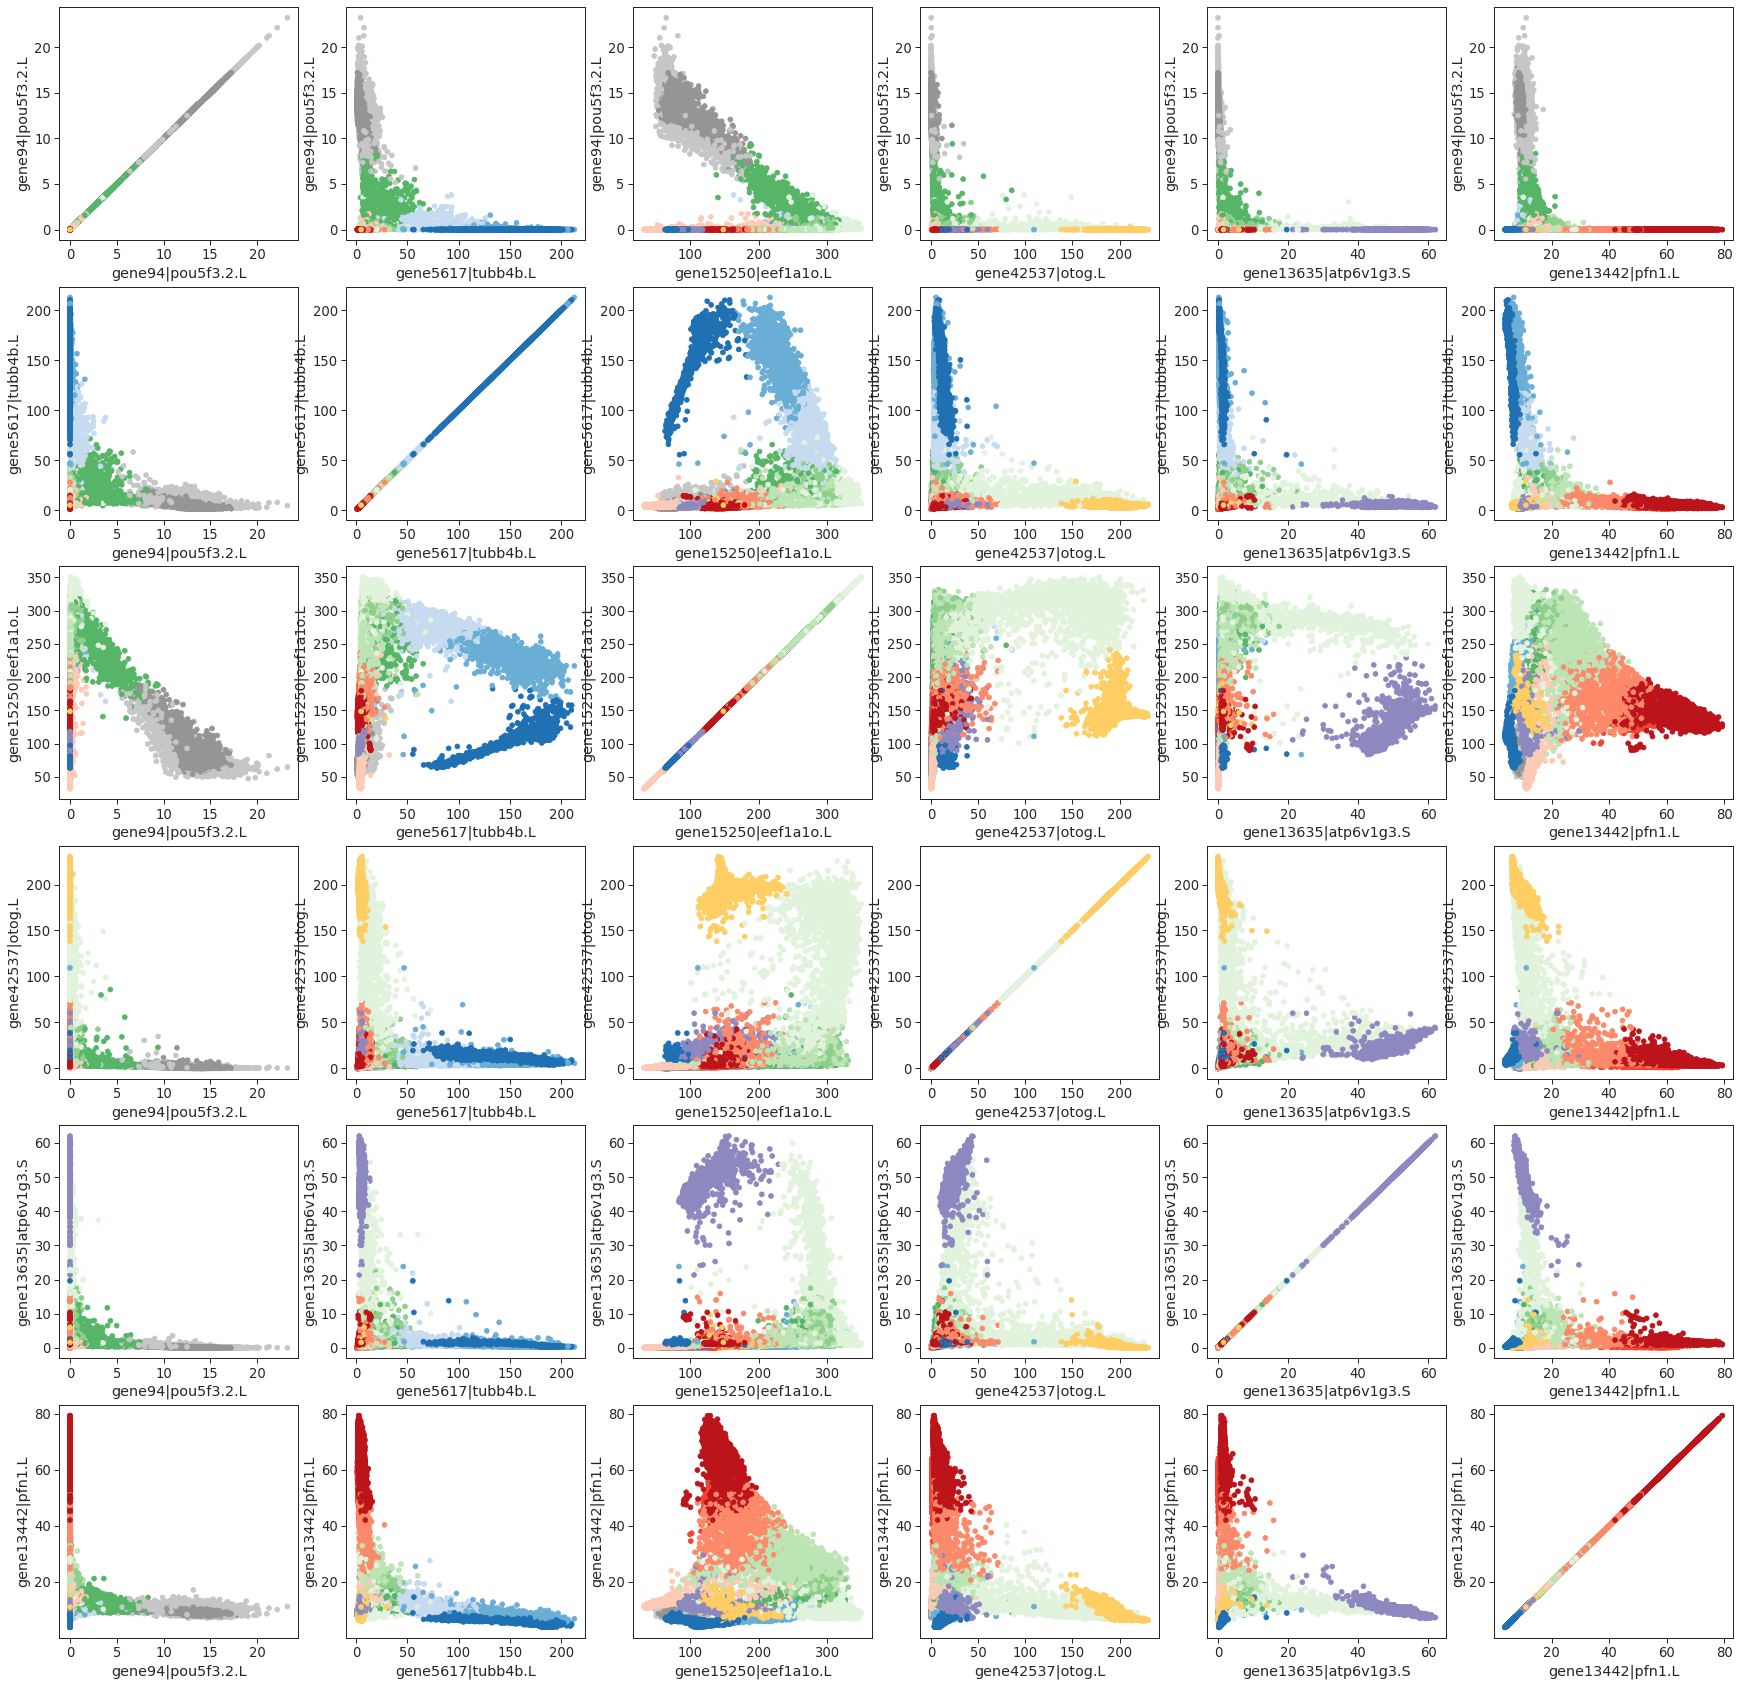

In [47]:

fig, axs = plt.subplots(len(other),len(otog),figsize = (5*len(otog),5*len(other) ))

for idx, i in enumerate(otog):
    for jdx, j in enumerate(other):
        axs[jdx, idx].scatter(x = imp_df.loc[:, i], y = imp_df.loc[:, j], color = clusters.map(colors.color), rasterized=True)
        axs[jdx, idx].set_xlabel(i)
        axs[jdx, idx].set_ylabel(j)
plt.savefig('figures/old_ marker_gene_scatter_corr_cluster.pdf')

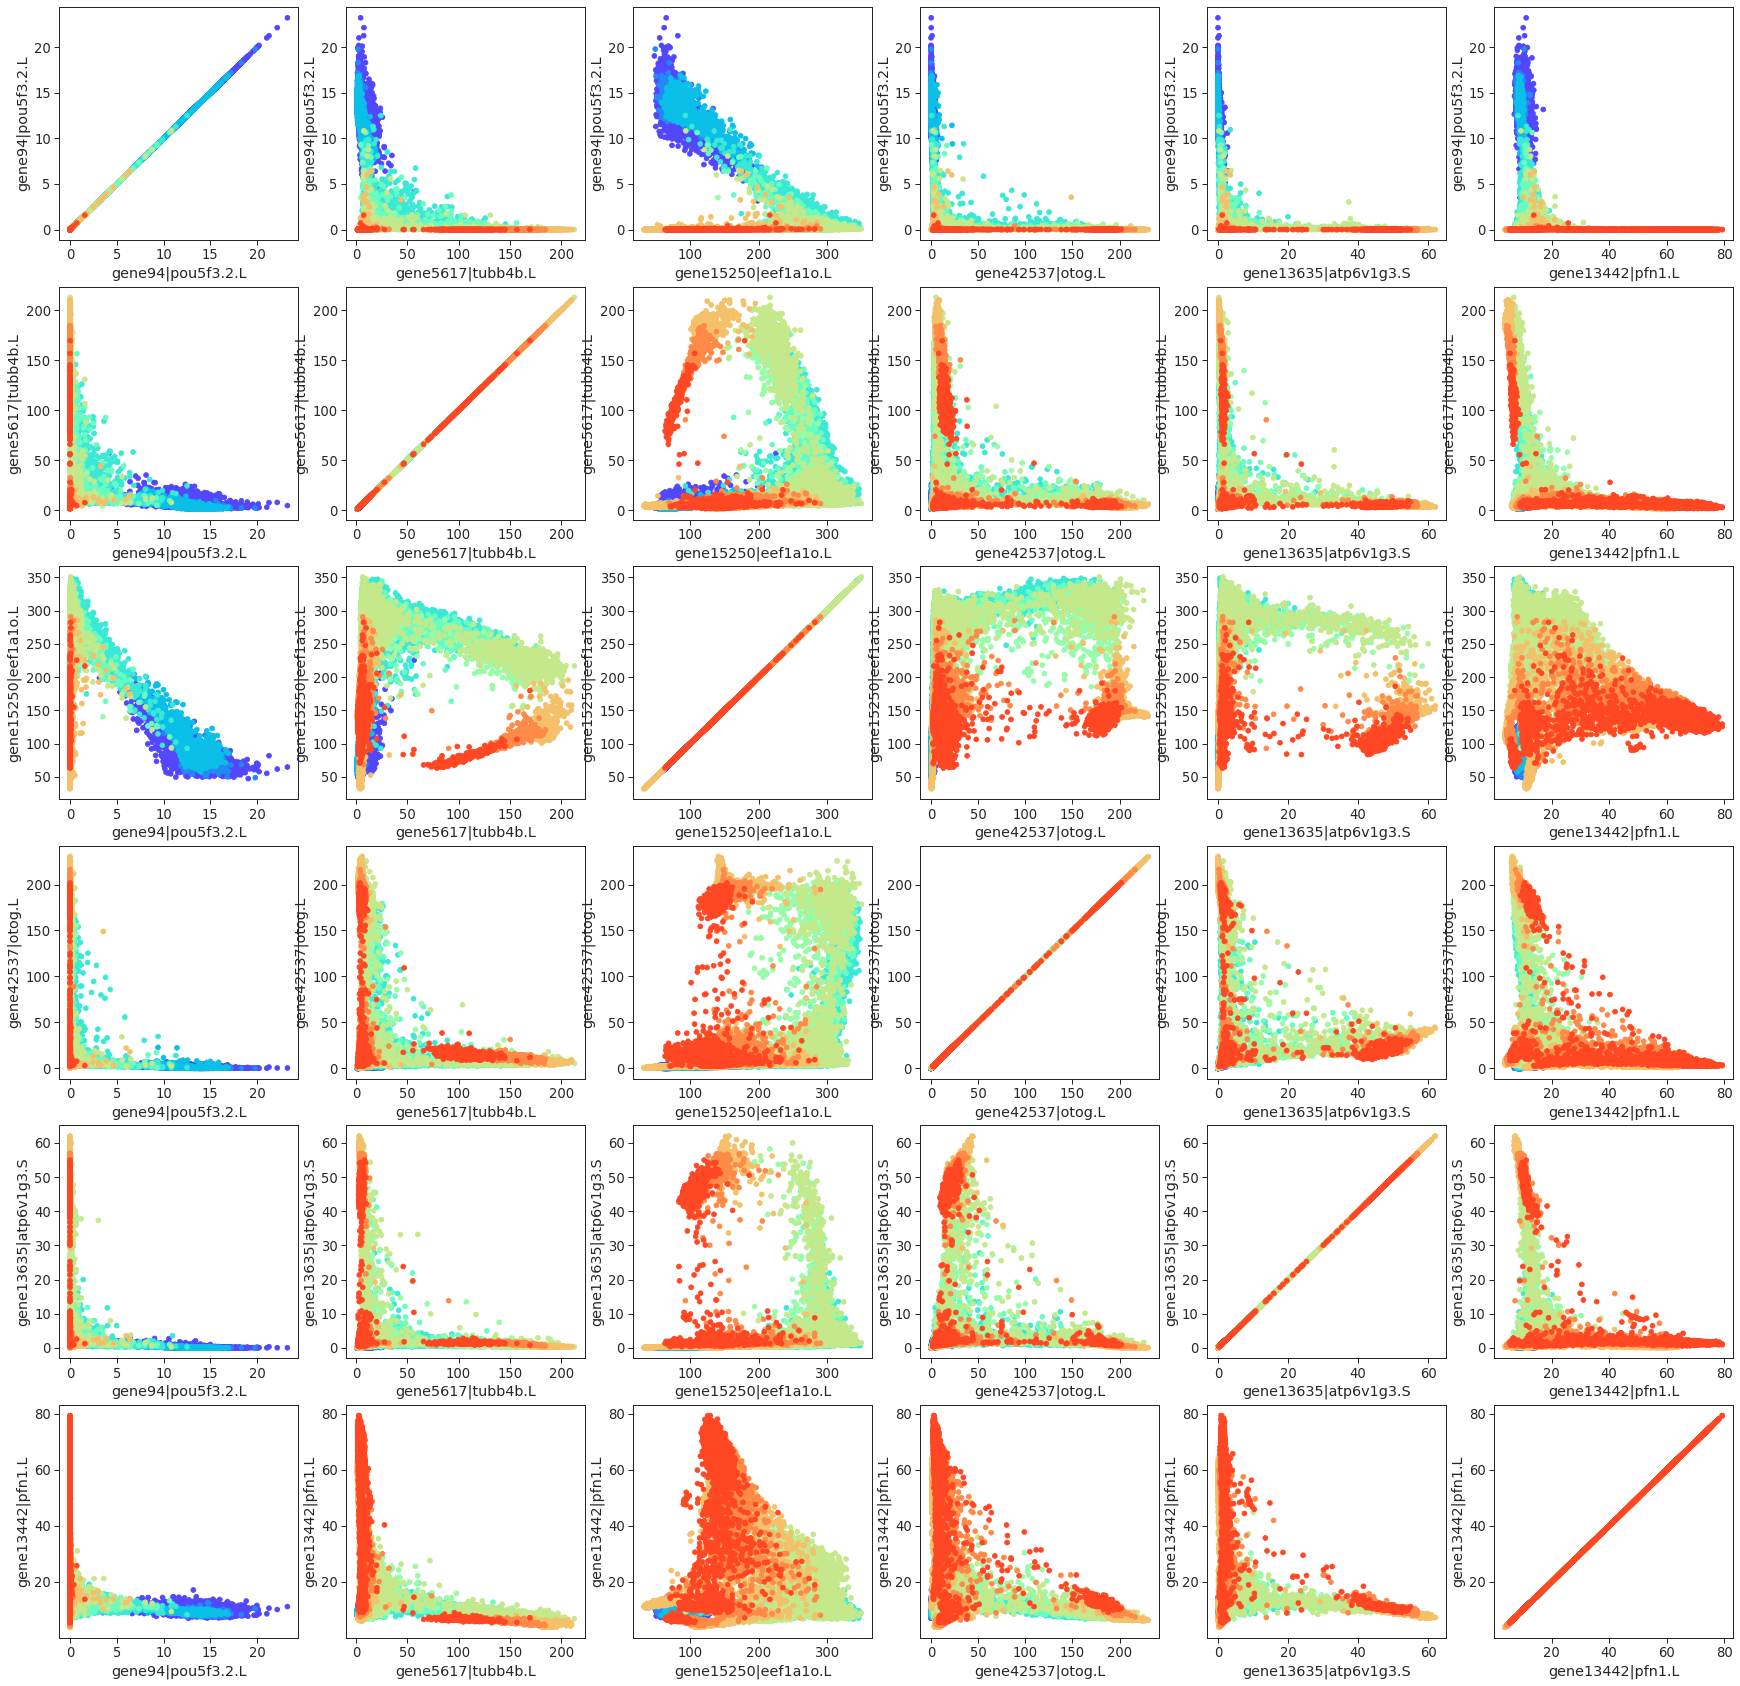

In [46]:

fig, axs = plt.subplots(len(other),len(otog),figsize = (5*len(otog),5*len(other) ))

for idx, i in enumerate(otog):
    for jdx, j in enumerate(other):
        axs[jdx, idx].scatter(x = imp_df.loc[:, i], y = imp_df.loc[:, j], c = tp.map(stage_colors), rasterized=True)
        axs[jdx, idx].set_xlabel(i)
        axs[jdx, idx].set_ylabel(j)
plt.savefig('figures/old_ marker_gene_scatter_corr_stage.pdf')

In [48]:
genes = ['gene1736|tp63.L',
'gene45646|atp6v1b1.L', 
'gene42537|otog.L', 
'gene16436|itln1.L', 
'gene13442|pfn1.L', 
'gene13000|foxa1.S', 
'gene9638|spdef.S', 
'gene5854|tekt2.S']

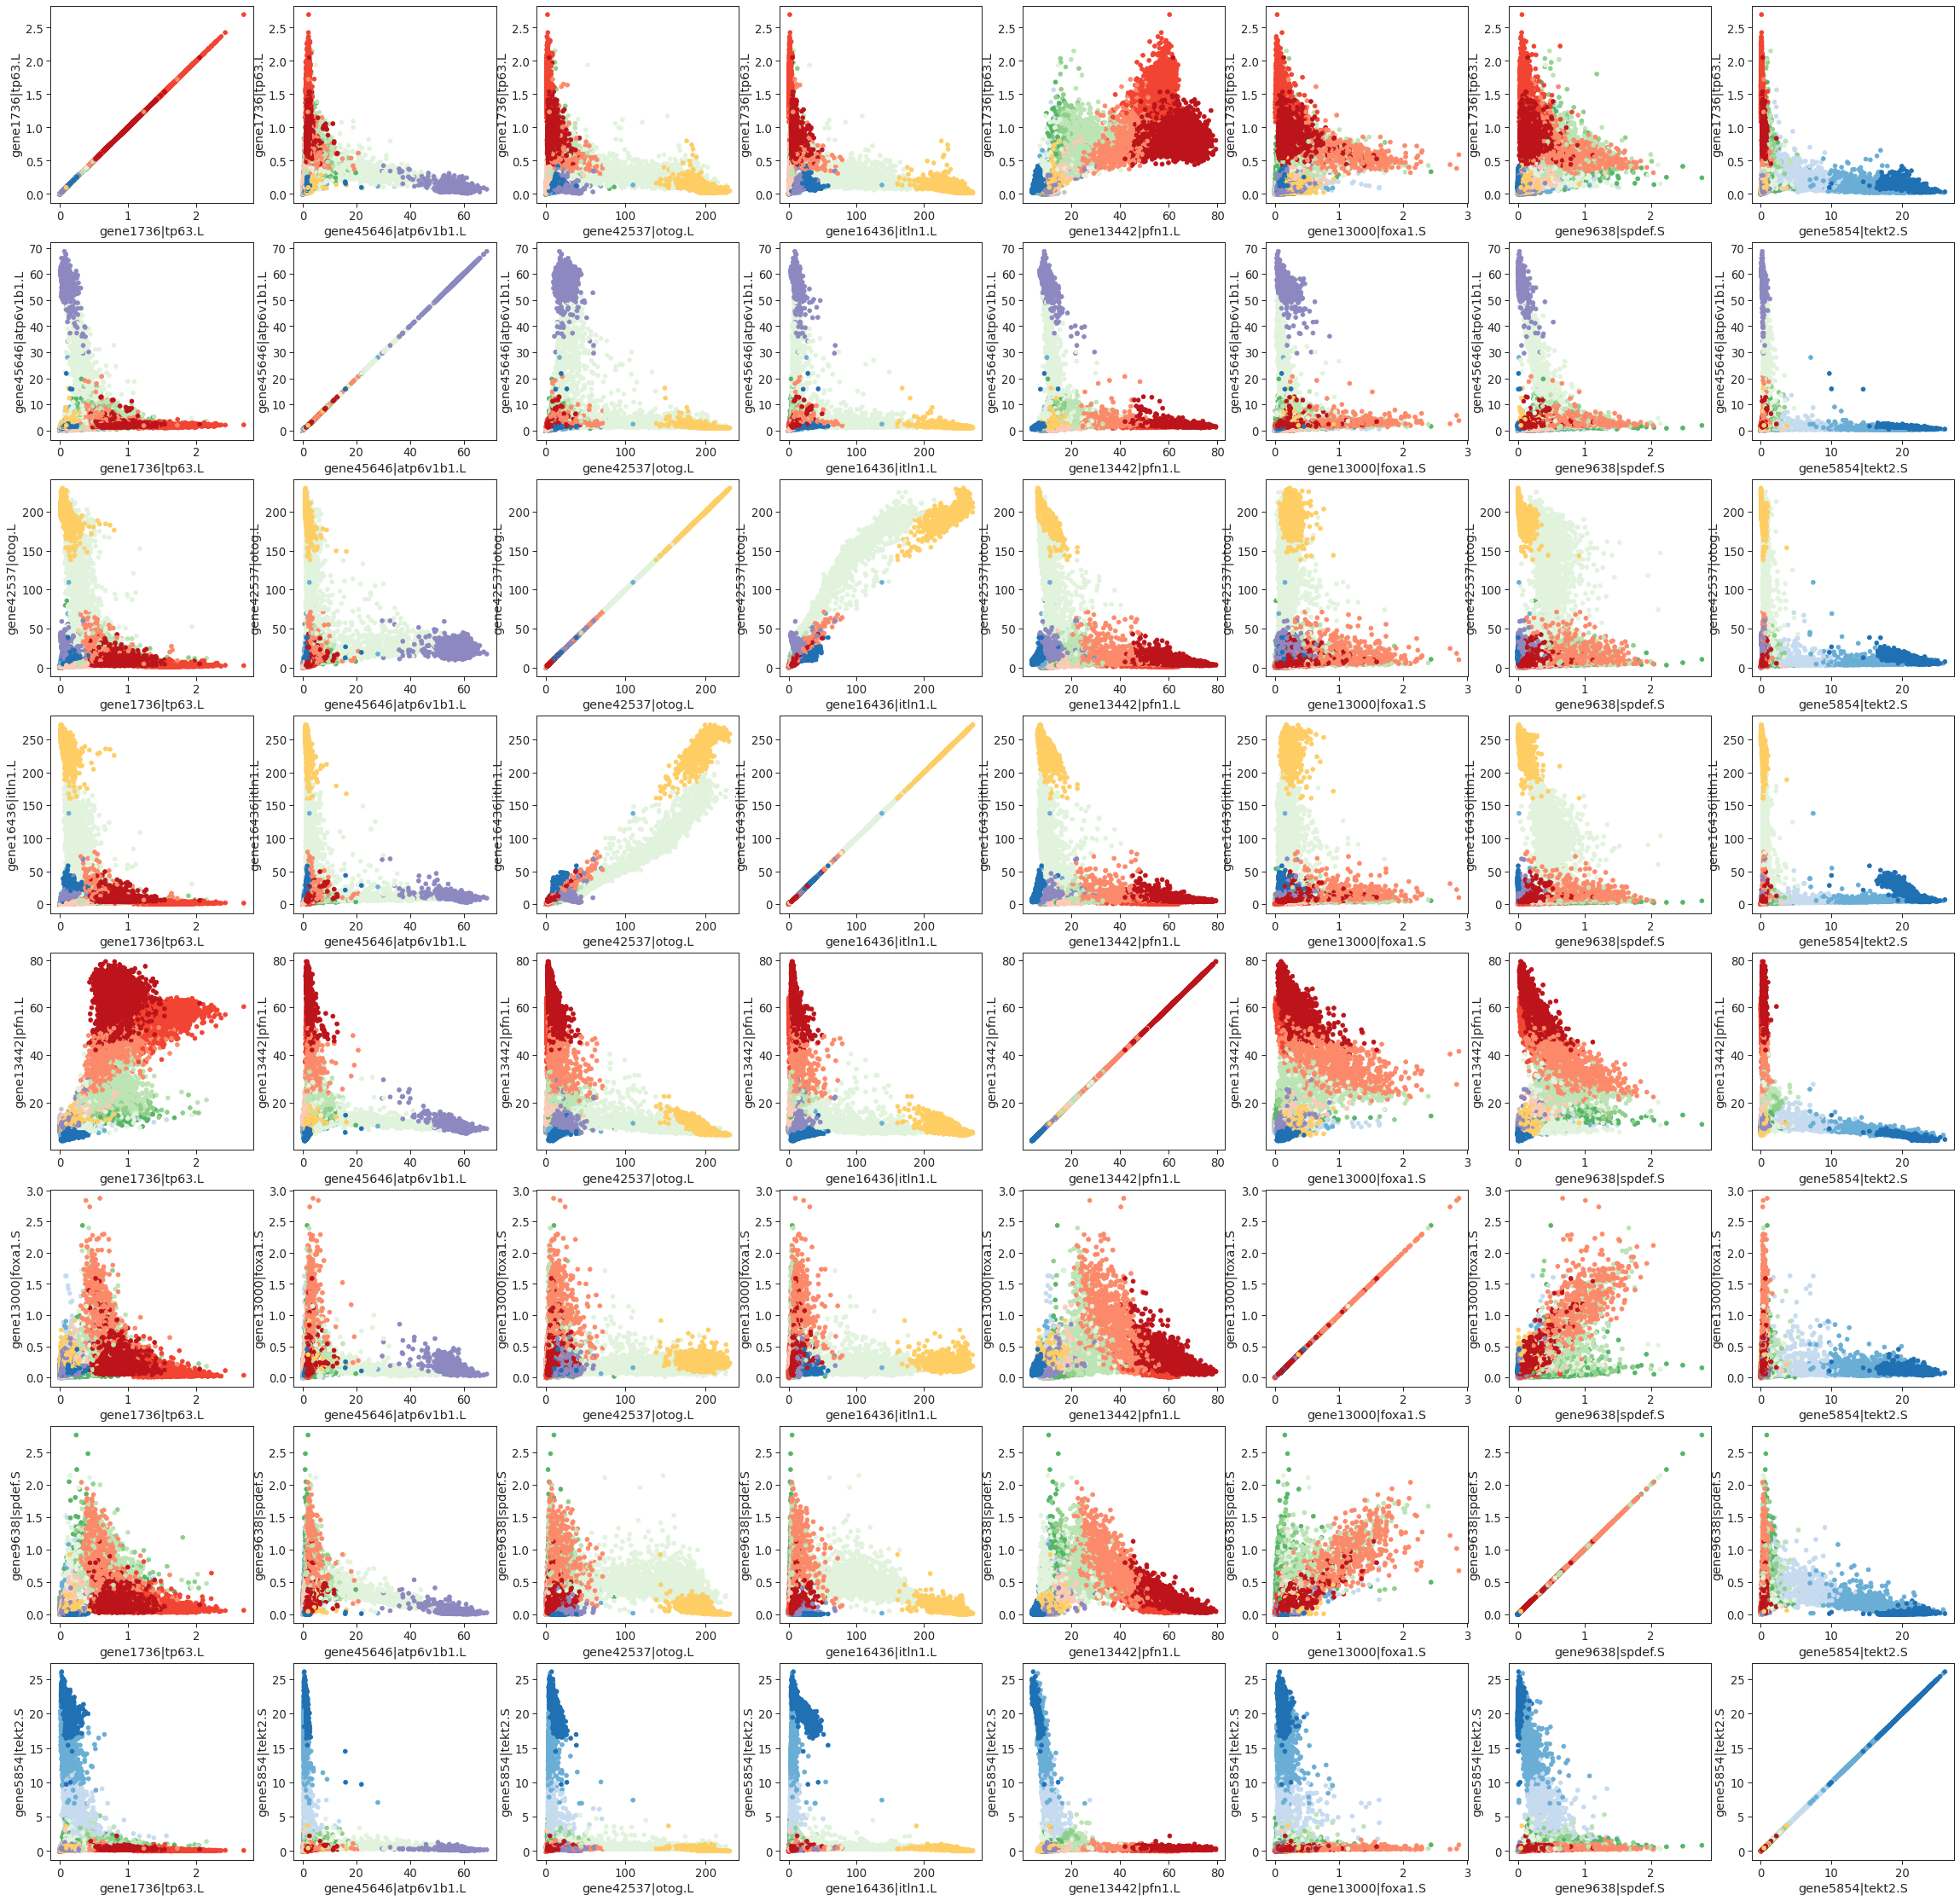

In [49]:

fig, axs = plt.subplots(len(genes),len(genes),figsize = (5*len(genes),5*len(genes) ))

for idx, i in enumerate(genes):
    for jdx, j in enumerate(genes):
        axs[jdx, idx].scatter(x = imp_df.loc[:, i], y = imp_df.loc[:, j], color = clusters.map(colors.color), rasterized=True)
        axs[jdx, idx].set_xlabel(i)
        axs[jdx, idx].set_ylabel(j)
plt.savefig('figures/marker_gene_scatter_corr_cluster.pdf')

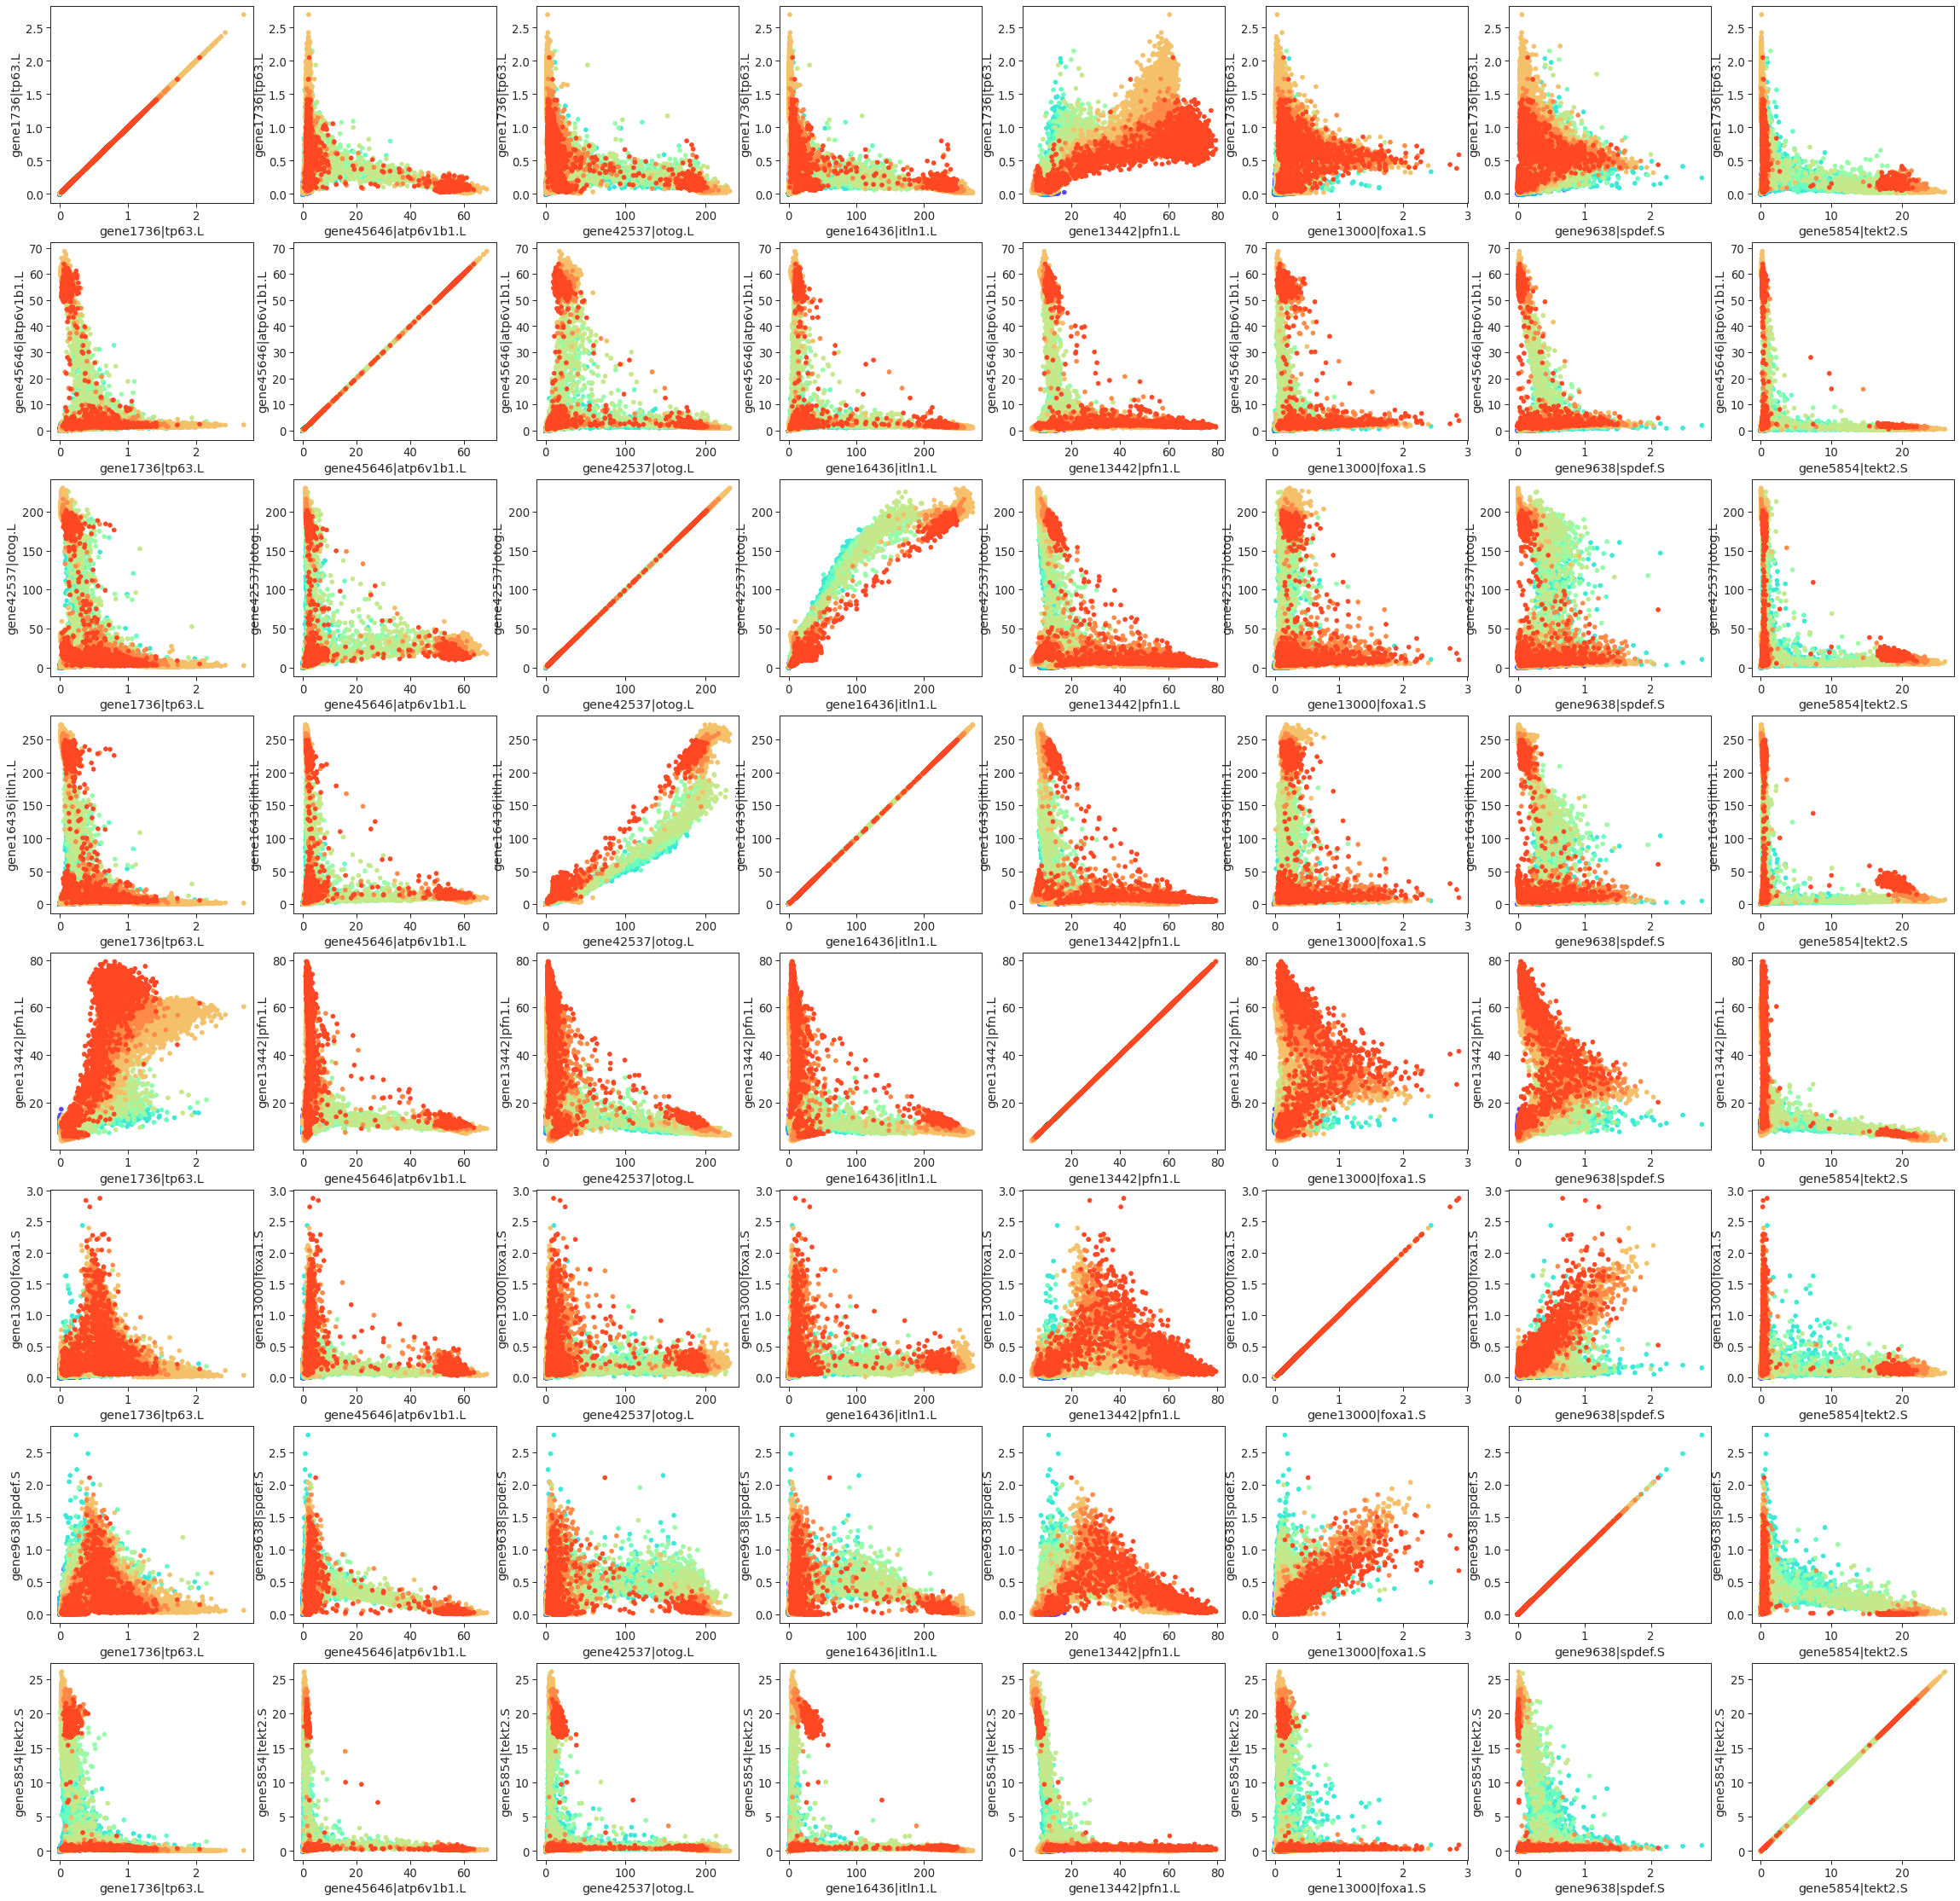

In [50]:

fig, axs = plt.subplots(len(genes),len(genes),figsize = (5*len(genes),5*len(genes) ))

for idx, i in enumerate(genes):
    for jdx, j in enumerate(genes):
        axs[jdx, idx].scatter(x = imp_df.loc[:, i], y = imp_df.loc[:, j], c = tp.map(stage_colors), rasterized=True)
        axs[jdx, idx].set_xlabel(i)
        axs[jdx, idx].set_ylabel(j)
plt.savefig('figures/marker_gene_scatter_corr_stage.pdf')